# Noise Filter

In [16]:
import time
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import torch, torch.nn as nn
from   torch.utils.data import Dataset, DataLoader
from   torchinfo        import summary  


## Dataset

Есть два класса: с линией - pos (1) и без линии - neg (0).<br> 
Для негативного класса добавляем случайные короткие штрихи для повышения стабильности модели (должна реагировать только на линии от одного края к другому.

In [ ]:
class CFG:
    width  = 360
    height = 360
    batch  = 16
    lr     = 1e-3
    L2     = 1e-5
    time   = 0

class GravWaveDataset(Dataset):    
    def __init__(self, n_samples=1024, height=360, width=360, signal_level=1, dash_size=20):
        self.n_samples    = n_samples
        self.height       = height
        self.width        = width
        self.signal_level = signal_level
        self.dash_size    = dash_size
    
    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        cl = np.random.randint(0,2)
        img = np.zeros((self.height, self.width), np.float32)
        if cl==0:
            for i in range(5):
                x1, y1 = np.random.randint(0,self.height), np.random.randint(0,self.height)                
                w      = np.random.randint(-self.dash_size, self.dash_size) 
                h      = np.random.randint(-self.dash_size, self.dash_size)
                x2, y2 = x1+w, y1+h
                img = cv.line(img, (x1,y1), (x2,y2),  self.signal_level, 1)
        else:
            y1, y2 = np.random.randint(0,self.height), np.random.randint(0,self.height)
            img = cv.line(img, (0,     y1), (self.width, y2),  self.signal_level,1)
            
        return np.reshape(img, (1, self.height, self.width)), cl

data   = GravWaveDataset(height = CFG.height, width = CFG.width)
loader = DataLoader(data, batch_size=CFG.batch, shuffle=False, pin_memory=True)   # num_workers=CFG["num_workers"]

def plot_samples(data, num = 5):
    """ show num samples of dataset in inverse style"""
    plt.figure(figsize=(num*4,4), facecolor ='w') 
    for i in range(num):
        plt.subplot(1, num, i+1)
        img, cl = data[i]
        img = img[0]
        plt.title(f"{cl}")
        plt.imshow(img.max()-img, cmap="gray", vmin=img.min(), vmax=img.max())
    plt.show()
plot_samples(data)             

## Model

In [ ]:
class CNN(nn.Module):
    """ 
    Модель с линейной cnn-архитерктурой (без resudial переходов) 
    """
    def __init__(self, 
                 shape   = (1, 64, 64),         # Input image shape (channels, height, width)                         
                 channels = [], conv_kernels=[], conv_stride=1,  paddings=None, mode='replicate',      # Conv2d
                 batchnorm=False,                                                
                 pool_kernel=2, pool_stride=2,  pool="max"):                     # pooling                                                                        
    
        super(CNN, self).__init__()

        if paddings          == None: paddings    = 0                            # default
        if type(paddings)    == int:  paddings    = [paddings]   *len(channels)
        if conv_stride       == None: conv_stride = 1                            # default
        if type(conv_stride) == int:  conv_stride = [conv_stride]*len(channels)
        if pool_kernel       == None: pool_kernel = 2                            # default
        if type(pool_kernel) == int:  pool_kernel = [pool_kernel]*len(channels)    
        if type(pool_stride) == int:  pool_stride = [pool_stride]*len(channels)        

        in_channels, h, w = shape                                                      
        channels = [in_channels] + channels
        self.layers = []
        for i in range(len(channels)-1):
            if conv_kernels[i]:
                self.layers +=  [ 
                    nn.Conv2d(channels[i], channels[i+1], kernel_size=conv_kernels[i], 
                              stride=conv_stride[i],  padding=paddings[i], padding_mode=mode),
                ]
                if batchnorm: # beetwen Line and non line   http://arxiv.org/pdf/1502.03167v2.pdf
                    self.layers += [ nn.BatchNorm2d(num_features=channels[i+1]) ]
                self.layers += [ nn.ReLU() ]             

                h = int( (h + 2*paddings[i] - conv_kernels[i]) / conv_stride[i] + 1)
                w = int( (w + 2*paddings[i] - conv_kernels[i]) / conv_stride[i] + 1)  

            if pool_kernel[i] > 1:
                if pool == 'max': self.layers += [nn.MaxPool2d(kernel_size=pool_kernel[i], stride=pool_stride[i]) ]
                else:             self.layers += [nn.AvgPool2d(kernel_size=pool_kernel[i], stride=pool_stride[i]) ]
                h = int( (h - pool_kernel[i]) / pool_stride[i] + 1)
                w = int( (w - pool_kernel[i]) / pool_stride[i] + 1)            
                
            self.output_size = h*w*channels[i+1]
            
        self.layers += [ nn.Flatten(1) ]
    
        self.model = nn.Sequential(*self.layers)                 
 
    def forward(self, x):               
        return self.model(x)

#--------------------------------------------------------------------------------------------    

class FCN(nn.Module):
    """     
    Полносвязная классификационная сеть с outputs выходами (1 - для 2-х классов) 
    """
    def __init__(self, 
                 n_inputs,            # число входов (признаков)
                 n_outputs = 1,      
                 dropout=0.2, 
                 hiddens=None):    
        super(FCN, self).__init__()
                
        self.layers = []
        hiddens = [n_inputs] + (hiddens or []) + [n_outputs]
        for i in range( len(hiddens)-1):
            if dropout > 0:        
                self.layers += [ nn.Dropout(p=dropout) ]
        
            self.layers += [ nn.Linear(hiddens[i], hiddens[i+1] ) ]
            if i < len(hiddens)-2:                    
                self.layers += [ nn.ReLU() ]

        self.model = nn.Sequential(*self.layers)                 
         
    def forward(self, x):               
        return self.model(x)

    
#--------------------------------------------------------------------------------------------    

class Model(nn.Module):
    def __init__(self, encoder, decoder, classifier):    
        super(Model, self).__init__()
        self.encoder    = encoder
        self.decoder    = decoder
        self.classifier = classifier
        self.noise      = torch.distributions.exponential.Exponential(torch.tensor([1.0]))
        
    def forward(self, x):               
        noise  = self.noise.sample(x.shape)        
        print(x.shape, noise.shape)
        encode = self.encoder(x + noise)           # исходная кратинка с шумом
        decode = self.decoder(x)
        y      = self.classifier(encode)
        return y, encode, decode


In [ ]:
encoder = CNN(shape = (1, CFG.height, CFG.width), 
              channels    = [2,2,2], 
              conv_kernels= [5,3,3],
              conv_stride = [1,1,1],            
            
              pool_kernel = 2,
              pool_stride = 2,
              batchnorm   = False)

decoder = CNN(shape = (1, CFG.height, CFG.width), 
              channels    = [2,2,2], 
              conv_kernels= [5,3,3],
              conv_stride = [1,1,1],            
            
              pool_kernel = 2,
              pool_stride = 2,
              batchnorm   = False)

if encoder.output_size != decoder.output_size:
    print("!!! Wrong output sizes of encoder or decoder !!!")

classifier = FCN(n_inputs = encoder.output_size)
model      = Model(encoder, decoder, classifier)

device = "cpu"          # torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#torch.cuda.empty_cache()
print(device)
model = model.to(device)

if False:
    print("encoder:", encoder.output_size)
    display(summary(encoder, (1,1,CFG.height,CFG.width), col_names=["input_size", "output_size", "num_params", "kernel_size"],col_width=20) )
    print("decoder:", decoder.output_size)
    display(summary(decoder, (1,1,CFG.height,CFG.width), col_names=["input_size", "output_size", "num_params", "kernel_size"],col_width=20) )
    print("classifier:")
    display(summary(classifier, (1,encoder.output_size), col_names=["input_size", "output_size", "num_params"],col_width=20) )

## Train

### Class Trainer

In [ ]:
class Trainer:
    def __init__(self, model, loader_trn, loader_val=None):    
        self.model      = model
        self.loader_trn = loader_trn
        self.loader_val = loader_val
        self.bceloss    = nn.BCEWithLogitsLoss() 
        self.optimizer  = torch.optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.L2)   
    
    def loss(self, y_true, y_pred, encode, decode):
        loss1 = ((encode - decode)**2).mean()
        loss2 = self.bceloss(y_pred, y_true)
        return loss1 + loss2

    def fit(self, loader, train=True):         
        """ One epoch training for DataLoader """    
        t1, t2, t3, t4, t5, start = 0,0,0,0,0, time.process_time()
        totLoss, totAcc, totNum   = 0,0,0       

        self.model.train(train)                             # important for Dropout, BatchNorm layers
        for sample in loader:                             
            beg = time.process_time()                        
            xb, yb = sample[0].to(device), sample[1].to(device)
            print("xb, yb", xb.shape, yb.shape)
            t1 += (time.process_time() - beg)

            beg = time.process_time()                            
            y, encode, decode = self.model(xb)              # forward propagation
            L = self.loss(yb, y, encode, decode)            # calculate the loss
            t2 += (time.process_time() - beg)

            if train:                                       # we are in learning mode
                beg = time.process_time()                            
                self.optimizer.zero_grad()                  # reset the gradients        
                L.backward()                                # calculate gradients           
                self.optimizer.step()                       # adjusting parameters
                t3 += (time.process_time() - beg)                                     
        
            beg = time.process_time()                                    
            totLoss += L.detach()                           # total loss (detach from graph)        
            a = y.data.argmax(axis=1)                   
            totAcc +=  (a == yb).float().mean()             # class definition accuracy
            totNum += 1
            t4 += (time.process_time() - beg)                                      

        beg = time.process_time()
        totLoss = totLoss.item()/totNum                     # item better hear (gpu!!!)
        totAcc  = totAcc.item() /totNum
        t5 = time.process_time() - beg

        info = f"gpu:{t1:.2f} nn:{t2:.2f} grad:{t3:.2f} met:{t4:.2f} av:{t5:.2f} tot:{time.process_time()-start:.2f}"
        return totLoss, totAcc, info             # mean loss and accuracy

    #-------------------------------------------------------------------------------
    
    def param_metrics(self, model):
        grads = []    
        with torch.no_grad():
            L2 = sum(p.data.pow(2).sum() for p in model.parameters()).cpu().item()
            for p in model.parameters():                 
                if not p.grad is None:
                    grads += [(((p.grad)**2).mean()**0.5).item()]
        return L2, grads

    #-------------------------------------------------------------------------------
    
    def smooth(self, x, beta=0.75): 
        """ Smoothing line plot """   
        av = np.copy(x)
        for i in range(1, len(x)):                
            av[i] = beta*av[i-1]+(1-beta)*x[i]        
        return av

    #-------------------------------------------------------------------------------
    
    def plot_train(self, history, grads, alpha=0.3):
        """ Plot loss and accuarcy: history = [epoch, L_trn, L_tst, L2, A_trn, A_tst] """
        h = np.array(history)                               # learning output
        plt.figure(figsize=(16,5), facecolor ='w')              
        ax1 = plt.subplot(1, 2, 1);  
        ax2=ax1.twinx()  
        ax3=ax1.twinx()      

        ax1.grid(color='gray', linestyle='--', alpha=0.6)
        ax1.set_xlabel('epoch');  ax1.set_ylabel('loss')
        ax1.set_title(f"loss_trn: {h[-1,1]:.4f}, loss_tst: {h[-1,2]:.4f}")

        ax3.plot(np.linspace(0, h[-1, 0],  len(grads)), grads, color="c", marker=".",  alpha=alpha)    
        ax3.set(  xlim=(0, len(grads) ) )
        ax3.legend(['grad'], loc='lower left')    
        ax3.axes.xaxis.set_visible(False); ax3.axes.yaxis.set_visible(False)  
        ax2.plot(h[:,0], h[:,3], ":r"); ax2.set_ylabel('L2');   
        ax2.legend(['L2'], loc='center left')    

        ax1.set( ylim=(0, 0.8), xlim=(0, h[-1,0]) )    
        ax1.plot(h[:,0], smooth(h[:, 1]), "-b")
        ax1.plot(h[:,0], smooth(h[:, 2]), "-g")      
        ax1.legend(['loss trn', 'loss tst'], loc='upper left')  
        ax1.plot(h[:,0], h[:, 1], "-b",  alpha=alpha)
        ax1.plot(h[:,0], h[:, 2], "-g",  alpha=alpha)

        ax = plt.subplot(1, 2, 2);      
        plt.xlabel('epoch'); plt.ylabel('accuracy');  ax.set_title(f"acc_trn: {h[-1,4]:.4f}, acc_tst: {h[-1,5]:.4f}")
        ax.set( ylim=(0.5, 1.0), xlim=(0, h[-1,0]) )
        plt.plot(h[:,0], smooth(h[:, 4]), "-b")
        plt.plot(h[:,0], smooth(h[:, 5]), "-g")
        ax.legend( ['acc trn', 'acc tst'], loc='upper left' )
        plt.plot(h[:,0], h[:, 4], "-b",  alpha=alpha)
        plt.plot(h[:,0], h[:, 5], "-g",  alpha=alpha)
        ax.grid(color='gray', linestyle='--', alpha=0.6)
    
        pars = [ f"{k:10s}: {v}\n" for k,v in CFG.items() ]
        ax.text(h[0,0]+5, 0.5, "".join(pars), {'fontsize':12, 'fontname':'monospace'})
        plt.show()
        
    #-------------------------------------------------------------------------------
    
    def run(self, epochs = 100):
        """        
        """
        self.model.to(device) # just in case
        L_val, A_val    = 0, 0
        L_trn, A_trn, _ = self.fit(self.loader_trn, train=False)
        print( "before:      loss: %8.6f accuracy: %.6f" % (L_trn, A_trn)  )

        history, losses, accs, beg, start = [], [], [], time.process_time(), time.process_time()
        for epoch in range(1, epochs+1):   
    
            L_trn, A_trn, info = self.fit(self.loader_trn, train=True)        # train one epoch
            losses.append(L); accs.append(A)    
    
            if self.loader_val:
                L_val, A_val, _ = self.fit(model, self.loader_val, train=False) 
                
            L2, grads = param_metrics(self.model.encoder)   

            if epoch % 1 == 0:                                                   # learning output   
                print(f"\repoch:{epoch:5d} loss:{L_trn:8.4f} ({L_val:8.4f}) L2:{L2:.4f} acc:{A_trn:.4f} ({A_val:.4f}) [{time.process_time()-beg:.1f}s] trn: {info}", end="")           
                beg = time.process_time()                

            history.append([epoch, L_trn, L_val, L2, A_trn, A_val])

            if epoch % 50  == 0 or epoch == epochs:
                CFG.time = f"{(time.process_time()-start)/epoch:.1f} s/ep [{(time.process_time()-start)/60:.1f} m]"
                self.plot_train(history, grads)        
        

### Run train

In [ ]:
trainer = Trainer(model, loader)
trainer.run()

### Confusion matrix

In [ ]:
from   sklearn.metrics import confusion_matrix
import seaborn as sn

matrix = confusion_matrix(Y_tst.numpy(), classes )

print("total accuracy:", matrix.diagonal().sum()/matrix.sum())
print("classes accuracy:", matrix.diagonal()/matrix.sum(axis=1))

matrix = matrix / matrix.sum(axis=1)
plt.figure(figsize = (5,5))
sn.heatmap(matrix, annot=True, cmap="Greys", annot_kws={"size": 12}, fmt=".3f", cbar=False)
plt.show()

## Remove noise

In [ ]:
noise = torch.distributions.exponential.Exponential(torch.tensor([1.0]))
noise.sample(x.shape)

## Some tests

In [251]:
class CFG:
    def str():
        return "hi"
    
print(CFG.str())

hi


(360, 1024)


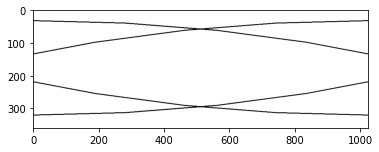

In [244]:
height, width  =  360, 1024
img = np.zeros((height,width), np.float32)

def draw_wave(img, y1, dy, eps=0.8, move_dn=1, curv_dn=1, color=1):
    h, w = img.shape
    a = (w**2 + dy**2 / eps**2) * eps/(2*dy)
    b, a = int( eps*a ), int(a)
    if move_dn==0 and curv_dn==1: f1, f2 = 0, 90                     
    if move_dn==1 and curv_dn==1: f1, f2 = 90, 180                   
    if move_dn==0 and curv_dn==0: f1, f2 = 270, 360                  
    if move_dn==1 and curv_dn==0: f1, f2 = 180, 270   
    posX = w     if move_dn else 0
    posY = -b+y1 if curv_dn else b+y1
    return cv.ellipse(img, (posX, posY), (a,b), 0,  f1, f2, color, 2)


def draw_rand_wave(img):
    h, w = img.shape
    curv_dn = np.random.randint(0,2)
    move_dn = np.random.randint(0,2) 
    eps     = np.random.uniform(0.5,0.9)
    if curv_dn:
        y1 = np.random.randint(h//2, h)
        dy = np.random.randint(5,h-y1-5)
    else:
        y1 = np.random.randint(0,h//2)
        dy = np.random.randint(5,h-y1-5)                
    return draw_wave(img, y1, dy, eps=0.6, move_dn=move_dn, curv_dn=curv_dn, color=1)
    

eps=0.6
img = draw_wave(img, y1=320, dy=100, eps=eps, move_dn=1, curv_dn=1)
img = draw_wave(img, y1=320, dy=100, eps=eps, move_dn=0, curv_dn=1)
img = draw_wave(img, y1=32,  dy=100, eps=eps, move_dn=1, curv_dn=0)
img = draw_wave(img, y1=32,  dy=100, eps=eps, move_dn=0, curv_dn=0)

#img = draw_rand_wave(img)
plt.imshow(img.max()-img, vmin=0, vmax=img.max()-img.min(), cmap="gray")

print(img.shape)

In [ ]:
nose_probs = np.exp(-1*np.linspace(0, 5, 256))
nose_probs /= nose_probs.sum()

noise = np.random.choice(len(nose_probs), (height,width), p=nose_probs)
img1 = (0.2*img + noise).clip(0,255)

plt.imshow(255 - img1, cmap="gray")
plt.show()

plt.plot(nose_probs)
plt.show()

In [ ]:
width, height, scale  = 4096, 360, 32

# create line:
signal_level = 1
img = np.zeros((height,width), np.float32)
y = 180 # np.random.randint(0,height)
img = cv.line(img, (0,     y),
                   (width, y), 
                    signal_level,1)

# create noise:
noise = np.random.exponential(scale=1.0, size=(height,width))
print(noise.mean(), noise.min(), noise.max())  # 1.0, 2e-8, 13

img += noise

# compress:
img = np.mean(img.reshape(height, width // scale, scale), axis=2)  

plt.figure(figsize=(8, 8), facecolor ='w')
img = img[:, 0:128]
plt.title(f"[{img.min():.2f}, {img.max():.2f}]")
plt.imshow(img.max()-img, cmap="gray", vmin=img.min(), vmax=img.max())
plt.show()

plt.hist(img.ravel(), bins=128, density=True, log=True); plt.grid()
plt.show()

In [14]:
360*360*8/(1024*1024)

0.98876953125

In [15]:
360*8

2880